In [1]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import os
import ast
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 14
import seaborn as sns
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import NASNetMobile, MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
start = dt.datetime.now()

In [16]:
DP_DIR = ''
INPUT_DIR = ''

BASE_SIZE = 256
NCSVS = 100
NCATS = 340
np.random.seed(seed=1987)
tf.set_random_seed(seed=1987)

def f2cat(filename: str) -> str:
    return filename.split('.')[0]

def list_all_categories():
    files = os.listdir(os.path.join(INPUT_DIR, '../../data/train_simplified'))
    return sorted([f2cat(f) for f in files], key=str.lower)

In [3]:
def apk(actual, predicted, k=3):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    if len(predicted) > k:
        predicted = predicted[:k]
    score = 0.0
    num_hits = 0.0
    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    if not actual:
        return 0.0
    return score / min(len(actual), k)

def mapk(actual, predicted, k=3):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

def preds2catids(predictions):
    return pd.DataFrame(np.argsort(-predictions, axis=1)[:, :3], columns=['a', 'b', 'c'])

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [4]:
STEPS = 800
EPOCHS = 16
size = 64
batchsize = 680

In [5]:
# model = NASNetMobile(input_shape=(size, size, 1), weights=None, classes=NCATS)
model = MobileNet(input_shape=(size, size, 1), alpha=1., weights=None, classes=NCATS)
model.compile(optimizer=Adam(lr=0.002), loss='categorical_crossentropy',
              metrics=[categorical_crossentropy, categorical_accuracy, top_3_accuracy])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 65, 65, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        288       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 32, 32, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 32, 32, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 32, 32, 32)        128       
__________

In [6]:
def draw_cv2(raw_strokes, size=256, lw=6, time_color=True):
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
    for t, stroke in enumerate(raw_strokes):
        for i in range(len(stroke[0]) - 1):
            color = 255 - min(t, 10) * 13 if time_color else 255
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                         (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size))
    else:
        return img

def image_generator_xd(size, batchsize, ks, lw=6, time_color=True):
    while True:
        for k in np.random.permutation(ks):
            filename = os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(k))
            for df in pd.read_csv(filename, chunksize=batchsize):
                df['drawing'] = df['drawing'].apply(ast.literal_eval)
                x = np.zeros((len(df), size, size, 1))
                for i, raw_strokes in enumerate(df.drawing.values):
                    x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw,
                                             time_color=time_color)
                x = preprocess_input(x).astype(np.float32)
                y = keras.utils.to_categorical(df.y, num_classes=NCATS)
                yield x, y

def df_to_image_array_xd(df, size, lw=6, time_color=True):
    df['drawing'] = df['drawing'].apply(ast.literal_eval)
    x = np.zeros((len(df), size, size, 1))
    for i, raw_strokes in enumerate(df.drawing.values):
        x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw, time_color=time_color)
    x = preprocess_input(x).astype(np.float32)
    return x

In [7]:
valid_df = pd.read_csv(os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(NCSVS - 1)), nrows=34000)
x_valid = df_to_image_array_xd(valid_df, size)
y_valid = keras.utils.to_categorical(valid_df.y, num_classes=NCATS)
print(x_valid.shape, y_valid.shape)
print('Validation array memory {:.2f} GB'.format(x_valid.nbytes / 1024.**3 ))

(34000, 64, 64, 1) (34000, 340)
Validation array memory 0.52 GB


In [8]:
train_datagen = image_generator_xd(size=size, batchsize=batchsize, ks=range(NCSVS - 1))

In [9]:
callbacks = [
    ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=5,
                      min_delta=0.005, mode='max', cooldown=3, verbose=1),
    ModelCheckpoint(filepath='model', verbose=1, save_best_only=True)
]
hists = []
hist = model.fit_generator(
    train_datagen, steps_per_epoch=STEPS, epochs=EPOCHS, verbose=1,
    validation_data=(x_valid, y_valid),
    callbacks = callbacks
)
hists.append(hist)

Epoch 1/16
799/800 [============================>.] - ETA: 0s - loss: 2.8478 - categorical_crossentropy: 2.8478 - categorical_accuracy: 0.3645 - top_3_accuracy: 0.5498
Epoch 00001: val_loss improved from inf to 2.59236, saving model to model
800/800 [==============================] - 237s 296ms/step - loss: 2.8467 - categorical_crossentropy: 2.8467 - categorical_accuracy: 0.3647 - top_3_accuracy: 0.5500 - val_loss: 2.5924 - val_categorical_crossentropy: 2.5924 - val_categorical_accuracy: 0.4052 - val_top_3_accuracy: 0.6265
Epoch 2/16
799/800 [============================>.] - ETA: 0s - loss: 1.6709 - categorical_crossentropy: 1.6709 - categorical_accuracy: 0.5869 - top_3_accuracy: 0.7838
Epoch 00002: val_loss improved from 2.59236 to 2.07292, saving model to model
800/800 [==============================] - 219s 274ms/step - loss: 1.6708 - categorical_crossentropy: 1.6708 - categorical_accuracy: 0.5869 - top_3_accuracy: 0.7838 - val_loss: 2.0729 - val_categorical_crossentropy: 2.0729 - 

In [10]:
hist = model.fit_generator(
    train_datagen, steps_per_epoch=STEPS, epochs=EPOCHS, verbose=1,
    validation_data=(x_valid, y_valid),
    callbacks = callbacks
)
hists.append(hist)

Epoch 1/16
799/800 [============================>.] - ETA: 0s - loss: 1.0009 - categorical_crossentropy: 1.0009 - categorical_accuracy: 0.7429 - top_3_accuracy: 0.8923
Epoch 00001: val_loss improved from 1.06868 to 1.03247, saving model to model
800/800 [==============================] - 233s 291ms/step - loss: 1.0008 - categorical_crossentropy: 1.0008 - categorical_accuracy: 0.7430 - top_3_accuracy: 0.8923 - val_loss: 1.0325 - val_categorical_crossentropy: 1.0325 - val_categorical_accuracy: 0.7334 - val_top_3_accuracy: 0.8866
Epoch 2/16
799/800 [============================>.] - ETA: 0s - loss: 0.9836 - categorical_crossentropy: 0.9836 - categorical_accuracy: 0.7468 - top_3_accuracy: 0.8953
Epoch 00002: val_loss did not improve from 1.03247
800/800 [==============================] - 231s 288ms/step - loss: 0.9836 - categorical_crossentropy: 0.9836 - categorical_accuracy: 0.7468 - top_3_accuracy: 0.8953 - val_loss: 1.0763 - val_categorical_crossentropy: 1.0763 - val_categorical_accurac

In [11]:
hist = model.fit_generator(
    train_datagen, steps_per_epoch=STEPS, epochs=EPOCHS, verbose=1,
    validation_data=(x_valid, y_valid),
    callbacks = callbacks
)
hists.append(hist)

Epoch 1/16
799/800 [============================>.] - ETA: 0s - loss: 0.8664 - categorical_crossentropy: 0.8664 - categorical_accuracy: 0.7764 - top_3_accuracy: 0.9106
Epoch 00001: val_loss improved from 0.86684 to 0.86172, saving model to model
800/800 [==============================] - 233s 291ms/step - loss: 0.8663 - categorical_crossentropy: 0.8663 - categorical_accuracy: 0.7765 - top_3_accuracy: 0.9106 - val_loss: 0.8617 - val_categorical_crossentropy: 0.8617 - val_categorical_accuracy: 0.7771 - val_top_3_accuracy: 0.9111
Epoch 2/16
799/800 [============================>.] - ETA: 0s - loss: 0.8524 - categorical_crossentropy: 0.8524 - categorical_accuracy: 0.7791 - top_3_accuracy: 0.9128
Epoch 00002: val_loss improved from 0.86172 to 0.85632, saving model to model
800/800 [==============================] - 229s 286ms/step - loss: 0.8523 - categorical_crossentropy: 0.8523 - categorical_accuracy: 0.7792 - top_3_accuracy: 0.9128 - val_loss: 0.8563 - val_categorical_crossentropy: 0.856

Epoch 16/16
799/800 [============================>.] - ETA: 0s - loss: 0.7670 - categorical_crossentropy: 0.7670 - categorical_accuracy: 0.7993 - top_3_accuracy: 0.9233
Epoch 00016: val_loss improved from 0.79838 to 0.79588, saving model to model
800/800 [==============================] - 230s 288ms/step - loss: 0.7669 - categorical_crossentropy: 0.7669 - categorical_accuracy: 0.7993 - top_3_accuracy: 0.9233 - val_loss: 0.7959 - val_categorical_crossentropy: 0.7959 - val_categorical_accuracy: 0.7933 - val_top_3_accuracy: 0.9197


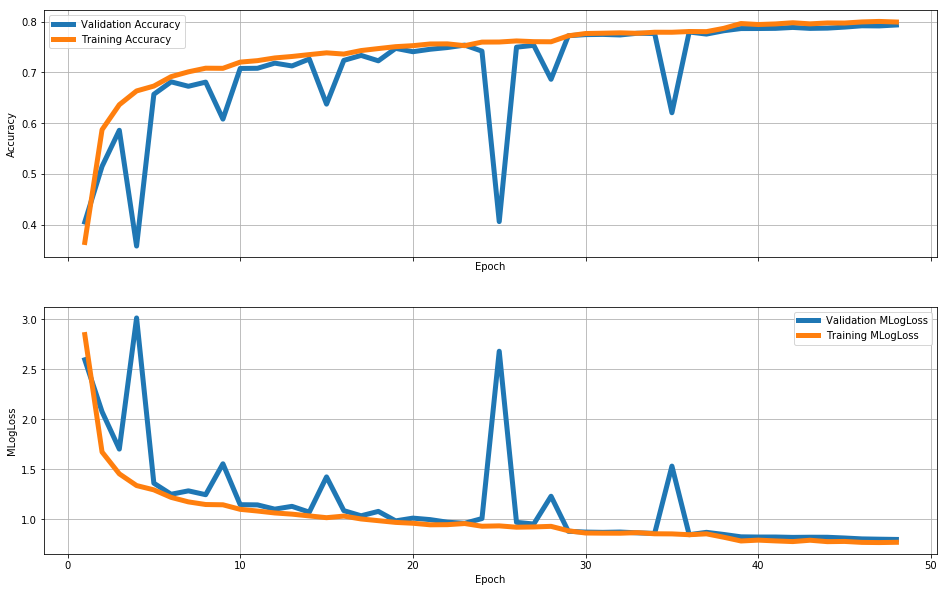

In [12]:
hist_df = pd.concat([pd.DataFrame(hist.history) for hist in hists], sort=True)
hist_df.index = np.arange(1, len(hist_df)+1)
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
axs[0].plot(hist_df.val_categorical_accuracy, lw=5, label='Validation Accuracy')
axs[0].plot(hist_df.categorical_accuracy, lw=5, label='Training Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].grid()
axs[0].legend(loc=0)
axs[1].plot(hist_df.val_categorical_crossentropy, lw=5, label='Validation MLogLoss')
axs[1].plot(hist_df.categorical_crossentropy, lw=5, label='Training MLogLoss')
axs[1].set_ylabel('MLogLoss')
axs[1].set_xlabel('Epoch')
axs[1].grid()
axs[1].legend(loc=0)
fig.savefig('hist.png', dpi=300)
plt.show();

In [13]:
valid_predictions = model.predict(x_valid, batch_size=128, verbose=1)
map3 = mapk(valid_df[['y']].values, preds2catids(valid_predictions).values)
print('Map3: {:.3f}'.format(map3))

34000/34000 [==============================] - 3s 102us/step
Map3: 0.849


In [14]:
test = pd.read_csv(os.path.join(INPUT_DIR, 'test_simplified.csv'))
test.head()
x_test = df_to_image_array_xd(test, size)
print(test.shape, x_test.shape)
print('Test array memory {:.2f} GB'.format(x_test.nbytes / 1024.**3 ))

,key_id,countrycode,drawing
0,9000003627287624,DE,"[[[17, 18, 20, 25, 137, 174, 242, 249, 251, 25..."
1,9000010688666847,UA,"[[[174, 145, 106, 38, 11, 4, 4, 15, 29, 78, 16..."
2,9000023642890129,BG,"[[[0, 12, 14, 17, 16, 24, 55, 57, 60, 79, 82, ..."
3,9000038588854897,US,"[[[0, 9, 23, 40, 54, 60, 81, 105, 123, 167, 20..."
4,9000052667981386,AR,"[[[87, 82, 71, 63, 66, 92, 96, 95], [220, 218,..."


(112199, 3) (112199, 64, 64, 1)
Test array memory 1.71 GB


In [17]:
test_predictions = model.predict(x_test, batch_size=128, verbose=1)

top3 = preds2catids(test_predictions)
top3.head()
top3.shape

cats = list_all_categories()
id2cat = {k: cat.replace(' ', '_') for k, cat in enumerate(cats)}
top3cats = top3.replace(id2cat)
top3cats.head()
top3cats.shape

112199/112199 [==============================] - 10s 85us/step


,a,b,c
0,234,281,285
1,144,36,226
2,305,62,110
3,187,303,223
4,113,56,112


(112199, 3)

,a,b,c
0,radio,stereo,stove
1,hockey_puck,bottlecap,pool
2,The_Great_Wall_of_China,castle,fence
3,mountain,tent,pliers
4,fireplace,campfire,fire_hydrant


(112199, 3)

In [18]:
test['word'] = top3cats['a'] + ' ' + top3cats['b'] + ' ' + top3cats['c']
submission = test[['key_id', 'word']]
submission.to_csv('gs_mn_submission_{}.csv'.format(int(map3 * 10**4)), index=False)
submission.head()
submission.shape

,key_id,word
0,9000003627287624,radio stereo stove
1,9000010688666847,hockey_puck bottlecap pool
2,9000023642890129,The_Great_Wall_of_China castle fence
3,9000038588854897,mountain tent pliers
4,9000052667981386,fireplace campfire fire_hydrant


(112199, 2)

In [ ]:
end = dt.datetime.now()
print('Latest run {}.\nTotal time {}s'.format(end, (end - start).seconds))